# Spam SMS Detection: Refined Project

In this notebook, I build a spam detection model using the SMS Spam Collection dataset.  
I cover:
- Data loading and cleaning
- Exploratory data analysis (EDA)
- Text preprocessing
- Building a pipeline with hyperparameter tuning
- Evaluation with error analysis
- Basic model interpretation

## Table of Contents
1. [Installation & Imports](#install)
2. [Data Loading & Cleaning](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Text Preprocessing](#preprocessing)
5. [Train-Test Split](#train-test-split)
6. [Pipeline & Hyperparameter Tuning](#pipeline)
7. [Evaluation & Error Analysis](#evaluation)
8. [Model Interpretation](#interpretation)
9. [Testing on New Messages](#testing)
10. [Conclusion](#conclusion)


In [29]:
# ==================================================
# 1. Installation & Imports
# ==================================================
# If needed, I can install missing libraries. On Kaggle, these are usually pre-installed.
!pip install --upgrade pip
!pip install joblib eli5

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

import joblib
import eli5

# I set the plot style and random seed for reproducibility.
sns.set(font_scale=1.1)
plt.style.use('seaborn')  # May show a deprecation warning, but it works fine.
np.random.seed(42)


<ipython-input-29-33077e0bb750>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # May show a deprecation warning, but it works fine.


<a id='data-loading'></a>
## 2. Data Loading & Cleaning

I load the SMS Spam Collection dataset and remove extra columns.


In [30]:
# I adjust the file path if necessary.
data_path = "/kaggle/input/sms-spam-collection-dataset/spam.csv"

# I read the CSV using 'latin-1' encoding to handle special characters.
df = pd.read_csv(data_path, encoding='latin-1')

# I rename columns for clarity.
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

# I drop extra columns that contain mostly NaN values.
cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
df.drop(columns=cols_to_drop, inplace=True)

print("=== Data Sample ===")
display(df.head())

print("\n=== Basic Info ===")
df.info()

print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Data Sample ===


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

=== Missing Values ===
label      0
message    0
dtype: int64


<a id='eda'></a>
## 3. Exploratory Data Analysis (EDA)

I examine the distribution of spam vs. ham messages.


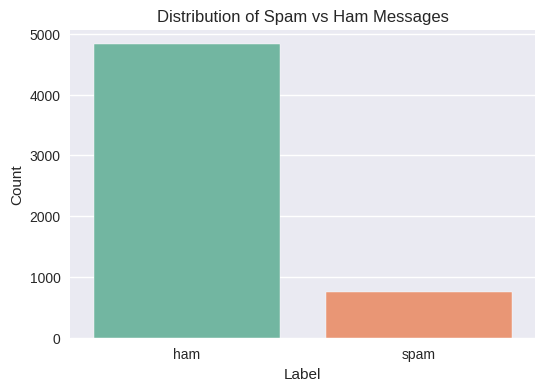

Label Counts:
label
ham     4825
spam     747
Name: count, dtype: int64


In [31]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print("Label Counts:")
print(df['label'].value_counts())


<a id='preprocessing'></a>
## 4. Text Preprocessing

I clean the messages by converting to lowercase, removing punctuation and digits, and stripping extra whitespace.


In [32]:
def clean_text(text):
    # Convert to lowercase.
    text = text.lower()
    # Remove punctuation and special characters.
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits.
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace.
    text = text.strip()
    return text

# I apply the text cleaning function to create a new column.
df['cleaned_message'] = df['message'].apply(clean_text)

print("=== Cleaned Sample Messages ===")
display(df[['message', 'cleaned_message']].head(5))


=== Cleaned Sample Messages ===


,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


<a id='train-test-split'></a>
## 5. Train-Test Split

I convert labels to numeric and split the data.


In [33]:
# Map labels to numeric values.
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Define features and target.
X = df['cleaned_message']
y = df['label_num']

# I perform an 80/20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size:  {X_test.shape[0]}")


Training set size: 4457
Testing set size:  1115


<a id='pipeline'></a>
## 6. Pipeline & Hyperparameter Tuning

I build a pipeline with TF-IDF vectorizer and Multinomial Naïve Bayes. I use GridSearchCV for tuning.


In [34]:
# I create the pipeline.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

# I define the parameter grid for GridSearchCV.
param_grid = {
    'tfidf__max_df': [0.5, 0.7, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Considering unigrams and bigrams.
    'clf__alpha': [0.1, 1.0, 5.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# I fit the grid search on the training data.
grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(grid_search.best_params_)
print("\nBest Cross-Validation Score: {:.3f}".format(grid_search.best_score_))


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters:
{'clf__alpha': 0.1, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}

Best Cross-Validation Score: 0.984


<a id='evaluation'></a>
## 7. Evaluation & Error Analysis

I evaluate the best model on the test set and list misclassified examples.


Test Set Accuracy: 0.98

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



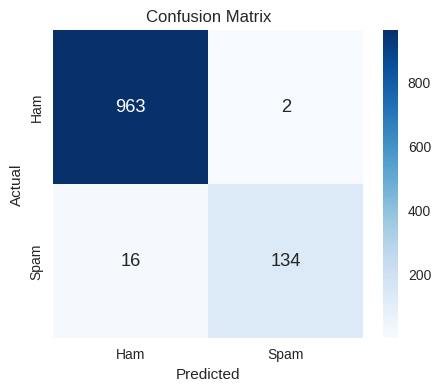

=== Misclassified Messages ===


683     hi im sue i am  years old and work as a lapdan...
3979                                         ringtoneking
1268    can u get  phone now i wanna chat  set up meet...
730     email alertfrom jeri stewartsize kbsubject low...
2662    hello darling how are you today i would love t...
4417                            when you get free call me
4296    thesmszonecom lets you send free anonymous and...
1468    hi its lucy hubby at meetins all day fri  i wi...
1047    s flirting now txt girl or bloke  ur name  age...
2351    download as many ringtones as u like no restri...
Name: cleaned_message, dtype: object

In [35]:
# I get the best estimator from grid search.
best_model = grid_search.best_estimator_

# I predict on the test set.
y_pred = best_model.predict(X_test)

# I calculate and print the overall accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}\n")

# I print a detailed classification report.
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# I plot the confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Error Analysis: I list some misclassified messages.
misclassified = X_test[y_test != y_pred]
print("=== Misclassified Messages ===")
display(misclassified.head(10))


<a id='interpretation'></a>
## 8. Model Interpretation

I manually extract and display the top features for each class (spam and ham) using the model's log probabilities. The higher the log probability for a feature in a given class, the more indicative it is of that class.


In [38]:
import numpy as np

# Get the feature names from the TF-IDF vectorizer.
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Get the log probabilities from the MultinomialNB classifier.
# Shape: (n_classes, n_features)
log_prob = best_model.named_steps['clf'].feature_log_prob_

def print_top_features(class_idx, class_name, top_n=20):
    top_indices = np.argsort(log_prob[class_idx])[-top_n:][::-1]
    print(f"Top features for {class_name}:")
    for idx in top_indices:
        print(f"{feature_names[idx]}: {log_prob[class_idx][idx]:.4f}")
    print("\n")

# Assuming class 0 corresponds to ham and class 1 to spam.
print_top_features(1, "spam", top_n=20)
print_top_features(0, "ham", top_n=20)


Top features for spam:
free: -5.7078
txt: -6.0537
claim: -6.0884
mobile: -6.0887
prize: -6.2019
stop: -6.2390
ur: -6.2659
text: -6.3242
won: -6.3963
reply: -6.3981
new: -6.4923
urgent: -6.5078
cash: -6.5665
nokia: -6.5677
service: -6.7022
win: -6.7296
contact: -6.7454
guaranteed: -6.7562
ppm: -6.8107
just: -6.8250


Top features for ham:
ok: -5.6257
im: -5.7490
ill: -6.0596
come: -6.1073
ltgt: -6.1593
just: -6.2058
dont: -6.2779
got: -6.3078
good: -6.3188
lor: -6.3309
home: -6.3333
sorry: -6.3339
time: -6.3528
know: -6.3674
like: -6.3901
later: -6.3930
going: -6.4088
ur: -6.4218
want: -6.5660
need: -6.5667




<a id='testing'></a>
## 9. Testing on New Messages

I define a function to predict new messages and test it.


In [37]:
def predict_message(message):
    """
    I predict whether a given message is spam or ham.
    """
    cleaned = clean_text(message)
    prediction = best_model.predict([cleaned])
    return 'Spam' if prediction[0] == 1 else 'Ham'

# I test the function with some sample messages.
sample_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now to claim your prize!",
    "Hey, are we still on for dinner tonight?",
    "URGENT! Your mobile number has won $5000. Reply with your bank details."
]

for msg in sample_messages:
    print(f"Message: {msg}")
    print(f"Prediction: {predict_message(msg)}\n")


Message: Congratulations! You've won a free ticket to the Bahamas. Call now to claim your prize!
Prediction: Spam

Message: Hey, are we still on for dinner tonight?
Prediction: Ham

Message: URGENT! Your mobile number has won $5000. Reply with your bank details.
Prediction: Spam



<a id='conclusion'></a>
## 10. Conclusion

I built a spam detection model using TF-IDF and Multinomial Naïve Bayes with hyperparameter tuning.  
This notebook shows the full ML workflow and provides insights into model performance and key features.  
